# Build an RL-Guided Fuzz Testing Engine for BSTs

In this tutorial, we will show how Atlas enables us to turn a dumb fuzzer into an effective rl-guided one.

Full paper with more in-depth examples coming soon!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## A Binary Search Tree Class
Let's first define a binary search tree class. 

In [2]:
# A binary search tree class
class BinarySearchTree:

    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None

    # Insert to_add into the tree
    def insert(self, to_add):
        if self.value == to_add:
            return
        if self.value > to_add:
            if self.left:
                self.left.insert(to_add)
            else:
                self.left = BinarySearchTree(to_add)
        else:
            if self.right:
                self.right.insert(to_add)
            else:
                self.right = BinarySearchTree(to_add)
    
    # Find whether to_find
    def find(self, to_find):
        if self.value == to_find:
            return self
        elif self.value > to_find:
            if self.left:
                return self.left.find(to_find)
            else:
                return None
        else:
            if self.right:
                return self.right.find(to_find)
            else:
                return None
            
    # Check whether the tree satisfies the binary search tree invariant. 
    # I.e., left child is a BST, right child is a BST, and self's value
    # is greater than the left child's value and smaller than the right
    # child's value.
    def is_bst(self):
        left_ok = True
        if self.left:
            left_ok = self.left.all_values_less_than(self.value) and self.left.is_bst()
        right_ok = True
        if self.right:
            right_ok = self.right.all_values_greater_than(self.value) and self.right.is_bst()
        return right_ok and left_ok

    # Helper method that returns true if all values in `self` are less than `value`
    def all_values_less_than(self, value):
        if self.value >= value:
            return False
        left_less_than = True
        if self.left:
            left_less_than = self.left.all_values_less_than(value)

        right_less_than = True
        if self.right:
            right_less_than = self.right.all_values_less_than(value)
        return left_less_than and right_less_than
    
    # Helper method that returns true if all values in `self` are greater than `value`
    def all_values_greater_than(self, value):
        if self.value <= value:
            return False
        left_greater_than = True
        if self.left:
            left_greater_than = self.left.all_values_greater_than(value)

        right_greater_than = True
        if self.right:
            right_greater_than = self.right.all_values_greater_than(value)
        return left_greater_than and right_greater_than

    def __repr__(self, indent=0):
        left_repr = self.left.__repr__(indent + 1) if self.left else " None"
        right_repr = self.right.__repr__(indent + 1) if self.right else " None"
        return f"({self.value}\n{indent*'  '}L{left_repr}\n{indent*'  '}R{right_repr})"


Say we want to test our insert function. One way to do this is to fuzz test: we'll generate many random trees, and try to insert random numbers into them, and check that the tree is still a binary search tree after insertion.

Because we're lazy, let's just write a generator that generates any binary search tree:

In [3]:
from atlas import generator

MAX_DEPTH = 4

@generator(strategy='randomized')
def generate_tree(depth=0):
    value = Select(range(0, 11))
    tree = BinarySearchTree(value) 
    if depth < MAX_DEPTH and Select([True, False]):
        tree.left = generate_tree(depth+1)
    if depth < MAX_DEPTH and Select([True, False]):
        tree.right = generate_tree(depth+1) 
    return tree 

Because we're lazy, this may not actually create trees that satisfy the binary search tree invariant. We can still use it for fuzzing if we call it enough times:

In [4]:
import random
TRIALS=10000

def test_insert(tree_generator):
    tree = tree_generator.call()
    to_add = random.choice(range(-10,20))
    if tree.is_bst():
        tree.insert(to_add)
        assert(tree.is_bst())
        return tree, True
    else:
        return tree, False

# Keep track of the valid BSTs we generate
def fuzz():
    n = 0
    num_bsts = 0
    unique_bsts = set()
    generator = generate_tree
    while n < TRIALS:
        tree, is_bst = test_insert(generator)
        if is_bst:
            num_bsts += 1
            unique_bsts.add(tree.__repr__())
        n += 1
        print(f"{n} trials, {num_bsts} binary search trees, {len(unique_bsts)} unique BSTs", end='\r')
    return unique_bsts
        
    

How well do we do with this randomized generation strategy?

In [5]:
bsts = fuzz()

1464 trials, 481 binary search trees, 329 unique BSTs

2723 trials, 879 binary search trees, 459 unique BSTs

3963 trials, 1292 binary search trees, 566 unique BSTs

6962 trials, 2260 binary search trees, 751 unique BSTs

8961 trials, 2945 binary search trees, 877 unique BSTs

Looks like around 10% of the randomly-generated inputs where unique BSTs. But what kind of binary search trees? Let's look at the distribution of sizes. 

([<matplotlib.axis.XTick at 0x1146dd1d0>,
 <a list of 6 Text xticklabel objects>)

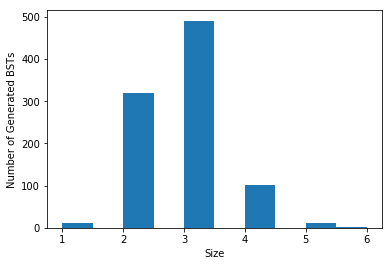

In [6]:
# Size is the number of nodes in the tree
sizes = [str_repr.count("(") for str_repr in bsts]
plt.hist(sizes)
plt.ylabel("Number of Generated BSTs")
plt.xlabel("Size")
plt.xticks(list(set(sizes)))

Hmm, looks like even though our naive random generator was able to generate some binary search trees, they weren't very complex. It had difficulty randomly creating valid binary search trees with more than 3 nodes, because it's randomly choosing which values to put in the tree with its Select operators.

What if we made those select operators smarter? In particular, what if we used reinforcement learning to decide what to do at each selection operator?

Let's start by defining a simple learner following a monte-carlo control policy. 

In [12]:
from numpy.random import binomial
from collections import defaultdict


class MCCLearner:

    def __init__(self,  epsilon=0.25, gamma=1.0, initial_val=0):
        self.epsilon = epsilon
        self.gamma = gamma
        self.episode = []
        self.initial_val = initial_val
        self.Q_table = defaultdict(dict)
        self.C_table = defaultdict(dict)

    # updates upon full episodes
    def reward(self, reward):
         # reward the last choice
         self.episode[-1][2] = reward
         T = len(self.episode)
         G = 0
         W = 1
         for i in range(T):
             s, a, r = self.episode[T - i - 1] # ranges from T-1, T-2, ... 0.
             G = self.gamma*G + r
             self.C_table[s][a] = self.C(s, a) + W
             self.Q_table[s][a] = self.Q(s, a) + (W/self.C(s, a)) * (G - self.Q(s, a))
         self.episode = []

    def Q(self, s: str, a: str):
        try:
            return self.Q_table[s][a]
        except KeyError:
            return self.initial_val

    def C(self, s: str, a: str):
        try:
            return self.C_table[s][a]
        except KeyError:
            return self.initial_val

    def policy(self, domain, state):
        domain = list(domain)
        # Epsilon-greedy strategy
        if binomial(1, self.epsilon):
            choice = random.choice(domain)
        else:
            self.action_values = np.array([self.Q(state, a) for a in domain])
            action_idx = random.choice(np.flatnonzero(self.action_values == self.action_values.max())) # break ties randomly
            choice = domain[action_idx]
        self.episode.append([state, choice, 0])
        return choice


We can now use these learners to back all our calls to Select. 

In [23]:
from typing import Callable, Optional, Collection

from atlas.operators import OpInfo
from atlas.strategies import Strategy, operator


class MCCStrategy(Strategy):
    
    def __init__(self):
        super().__init__()
        self.learners = {}
        
    def generic_call(self, domain=None, context=None, op_info: OpInfo = None, handler: Optional[Callable] = None,
                     **kwargs):
        return handler(domain=domain, context=context, op_info=op_info, **kwargs)

    def is_finished(self):
        return False
    
    def get_learner(self, sid):
        if sid not in self.learners:
            self.learners[sid] = MCCLearner()
        return self.learners[sid]
    
    def reward(self, r):
        for learner in self.learners.values():
            learner.reward(r)
        
    @operator
    def Select(self, domain, op_info=None, context=None, **kwargs):
        sid = op_info.sid
        learner = self.get_learner(sid)
        choice = learner.policy(domain, context.__repr__())
        return choice


Now, we just need to modify our generator to add some minimal context for each call:

In [24]:
mcc_strategy = MCCStrategy()

WINDOW_SIZE = 4
def concat_tail(lst, val):
    return (lst + [val])[-WINDOW_SIZE:]

@generator(strategy=mcc_strategy)
def generate_tree(context, depth=0):
    value = Select(range(0, 11), context=context)
    # Add the last choice of value to the context
    context = concat_tail(context, value)
    tree = BinarySearchTree(value) 
    if depth < MAX_DEPTH and Select([True, False], context=context):
        # We're generating the left child now
        tree.left = generate_tree(concat_tail(context, "LEFT"), depth+1)
    if depth < MAX_DEPTH and Select([True, False], context=context):
        # We're generating the right child now
        tree.right = generate_tree(concat_tail(context, "RIGHT"), depth+1) 
    return tree 

Let's try fuzzing again, this time rewarding the strategy if it generates a new binary search tree:

In [25]:
def test_insert(tree_generator):
    tree = tree_generator.call([])
    to_add = random.choice(range(-10,20))
    if tree.is_bst():
        tree.insert(to_add)
        assert(tree.is_bst())
        return tree, True
    else:
        return tree, False


# Keep track of the valid BSTs we generate
def fuzz():
    n = 0
    num_bsts = 0
    unique_bsts = set()
    generator = generate_tree
    while n < TRIALS:
        tree, is_bst = test_insert(generator)
        if is_bst:
            num_bsts += 1
            tree_repr = tree.__repr__()
            if tree_repr not in unique_bsts:
                unique_bsts.add(tree_repr)
                mcc_strategy.reward(20)
            else:
                mcc_strategy.reward(0)
        else:
            mcc_strategy.reward(-1)
        n += 1
        print(f"{n} trials, {num_bsts} binary search trees, {len(unique_bsts)} unique BSTs", end='\r')
    return unique_bsts
        

In [26]:
trees = fuzz()

1022 trials, 799 binary search trees, 428 unique BSTs

1438 trials, 1119 binary search trees, 555 unique BSTs

1793 trials, 1349 binary search trees, 660 unique BSTs

2240 trials, 1648 binary search trees, 767 unique BSTs

2639 trials, 1926 binary search trees, 895 unique BSTs

2994 trials, 2180 binary search trees, 1008 unique BSTs

3389 trials, 2459 binary search trees, 1141 unique BSTs

3777 trials, 2712 binary search trees, 1272 unique BSTs

4207 trials, 3048 binary search trees, 1410 unique BSTs

4603 trials, 3340 binary search trees, 1512 unique BSTs

4985 trials, 3596 binary search trees, 1625 unique BSTs

5316 trials, 3794 binary search trees, 1709 unique BSTs

5714 trials, 4048 binary search trees, 1822 unique BSTs

6044 trials, 4259 binary search trees, 1935 unique BSTs

6396 trials, 4489 binary search trees, 2031 unique BSTs

7244 trials, 5045 binary search trees, 2280 unique BSTs

7918 trials, 5437 binary search trees, 2487 unique BSTs

8182 trials, 5588 binary search trees, 2557 unique BSTs

8472 trials, 5766 binary search trees, 2652 unique BSTs

9156 trials, 6221 binary search trees, 2867 unique BSTs

9982 trials, 6798 binary search trees, 3132 unique BSTs

([<matplotlib.axis.XTick at 0x114bc4828>,
 <a list of 7 Text xticklabel objects>)

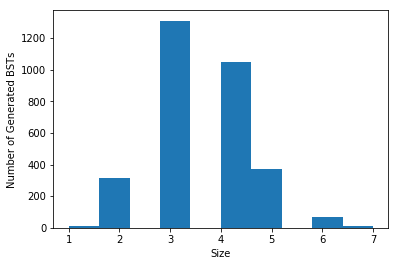

In [27]:
# Size is the number of nodes in the tree
sizes = [str_repr.count("(") for str_repr in trees]
plt.hist(sizes)
plt.ylabel("Number of Generated BSTs")
plt.xlabel("Size")
plt.xticks(list(set(sizes)))